# notebook to extract the true information from the MC


- Load in MC (particles)
- Extract only events that pass the criteria (double escape peak e+e- events)
- Create two subset lists (sig/back) to separate out the data.

In [3]:
# load in the data


# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

from concurrent.futures import ProcessPoolExecutor


import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

In [4]:
!pwd

/scratch/halmazan/NEXT/testing/notebooks


In [5]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'MC', 'particles')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks

In [6]:
mc_path = '/data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/' # then the ldcs

In [7]:
LDC = 1
full_path = f'{mc_path}ldc{LDC}/'

file_names = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f)) and f.endswith('.h5')]

# Test reading a single file
test_file_path = os.path.join(full_path, file_names[0])  # Replace 'test_file.h5' with an actual file name in the directory
MC_df = load_single_file(test_file_path)
hits_df = pd.read_hdf(test_file_path, 'MC/hits')

# Display the first few rows of the dataframe
pd.set_option('display.max_columns', None)
display(MC_df.head())
print(MC_df.columns.values)
print(MC_df.initial_volume.unique())
display(hits_df)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,226716000,1,Tl208,True,0,399.106079,401.554993,564.30719,0.000000,399.106079,401.554993,564.307190,0.000587,TH228,TH228,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,226716000,4,e-,False,1,399.106079,401.554993,564.30719,0.000587,399.133789,401.536591,564.363159,0.001457,TH228,TH228_SOURCE_SUPPORT,0.679778,0.310396,0.058041,-0.000000,-0.0000,-0.000000,0.396157,0.225791,RadioactiveDecay,NoProcess
2,226716000,3,anti_nu_e,False,1,399.106079,401.554993,564.30719,0.000587,-12500.000000,-4757.817871,-2359.398438,47.356602,TH228,WORLD,-1.276566,-0.510600,-0.289346,-1.276566,-0.5106,-0.289346,1.405010,14196.975586,RadioactiveDecay,Transportation
3,226716000,2,Pb208[3197.711],False,1,399.106079,401.554993,564.30719,0.000587,399.106079,401.554993,564.307190,0.000587,TH228,TH228,0.596783,0.200203,0.231303,0.000000,0.0000,0.000000,0.000001,0.000000,RadioactiveDecay,RadioactiveDecay
4,226716000,6,gamma,False,2,399.106079,401.554993,564.30719,0.000587,440.988129,446.868347,605.252014,0.311211,TH228,ICS,0.257578,0.206693,0.480666,0.000000,0.0000,0.000000,0.583188,93.122765,RadioactiveDecay,phot


['event_id' 'particle_id' 'particle_name' 'primary' 'mother_id'
 'initial_x' 'initial_y' 'initial_z' 'initial_t' 'final_x' 'final_y'
 'final_z' 'final_t' 'initial_volume' 'final_volume' 'initial_momentum_x'
 'initial_momentum_y' 'initial_momentum_z' 'final_momentum_x'
 'final_momentum_y' 'final_momentum_z' 'kin_energy' 'length'
 'creator_proc' 'final_proc']
['TH228' 'ICS' 'ACTIVE' 'FIELD_RING' 'LIGHT_TUBE_DRIFT' 'STAVE'
 'PORT_TUBE_1a' 'TH228_SOURCE_SUPPORT' 'EP_COPPER_PLATE' 'VESSEL_GAS'
 'TP_COPPER_PLATE' 'BUFFER' 'GATE_RING' 'LEAD_BOX' 'STEEL_BOX'
 'SIPM_BOARD_MASK' 'HDPE_TUBE' 'CATHODE_RING' 'CATHODE_GRID'
 'SIPM_BOARD_MASK_HOLE' 'SIPM_BOARD' 'PMT' 'PMT_WINDOW']


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,226716000,41,0,159.825882,310.863373,461.121735,0.920929,0.000048,ACTIVE
1,226716000,45,0,159.826111,310.863281,461.121704,0.920992,0.000044,ACTIVE
2,226716000,44,0,159.825943,310.863159,461.121887,0.921000,0.000045,ACTIVE
3,226716000,43,0,159.825195,310.863251,461.122467,0.921002,0.000553,ACTIVE
4,226716000,42,0,158.936218,310.508759,460.834229,0.924321,0.000447,ACTIVE
...,...,...,...,...,...,...,...,...,...
99091,226716087,41,451,239.237305,403.086517,568.762634,1.814028,0.000014,ACTIVE
99092,226716087,41,452,239.237442,403.085754,568.764099,1.814090,0.000362,ACTIVE
99093,226716087,41,453,239.237930,403.085785,568.765198,1.814140,0.000031,ACTIVE
99094,226716087,41,454,239.238144,403.086700,568.766052,1.814193,0.000289,ACTIVE


Number of events in active volume: 88
Number of positron events: 13
Number of positron events with conv creator proc: 13


array([226716009, 226716013, 226716015, 226716038, 226716043, 226716054,
       226716057, 226716062, 226716063, 226716067, 226716068, 226716080,
       226716081])

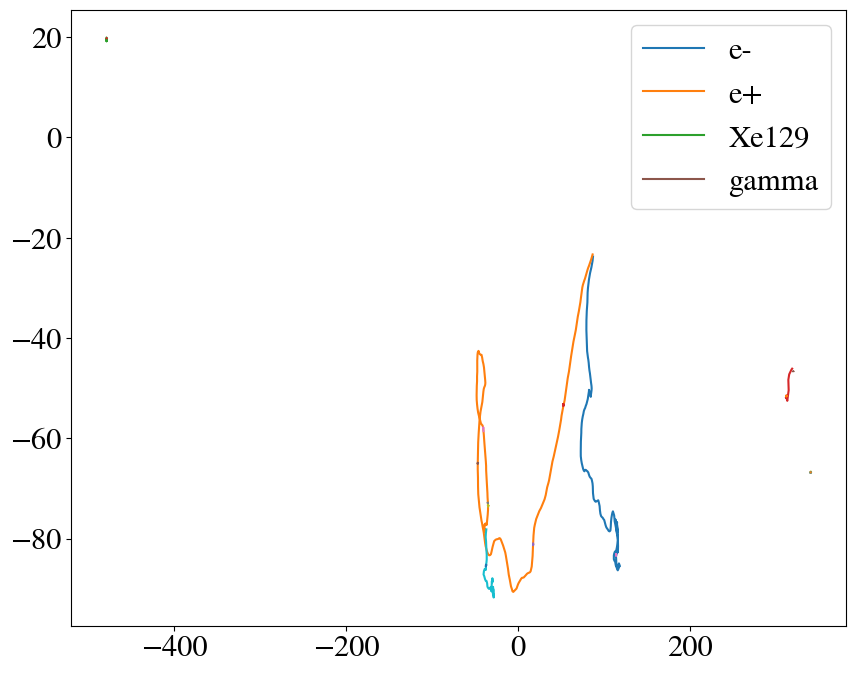

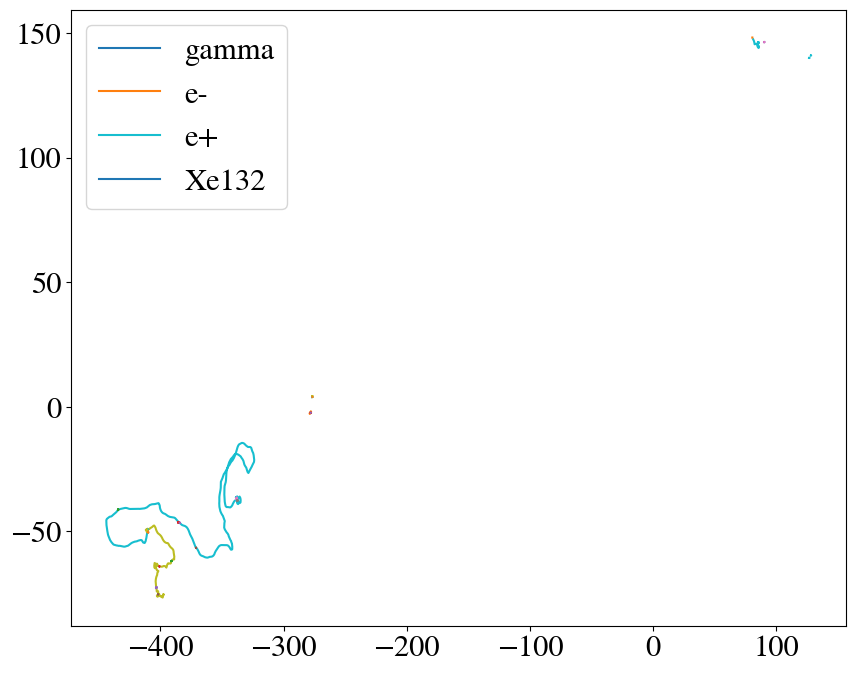

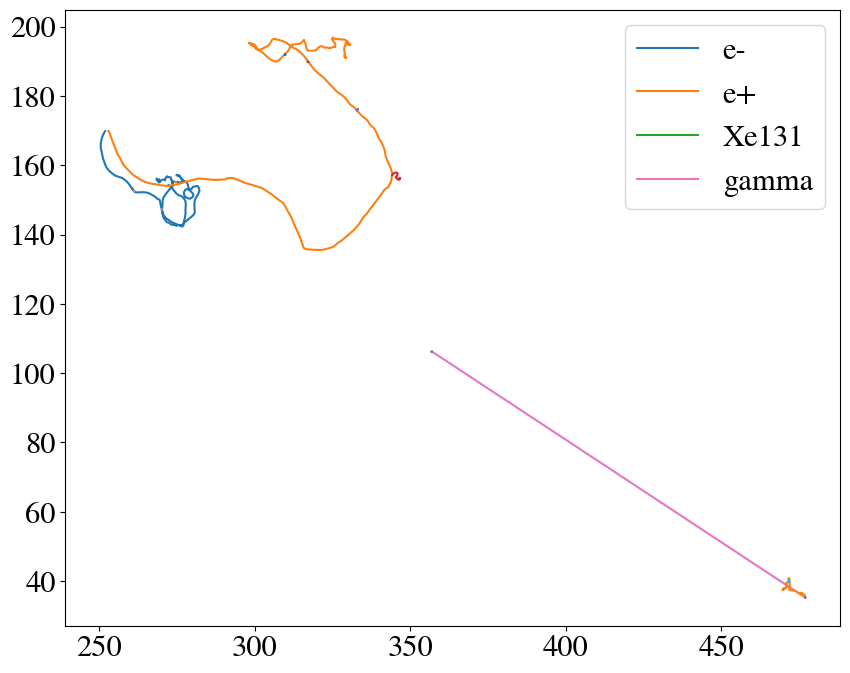

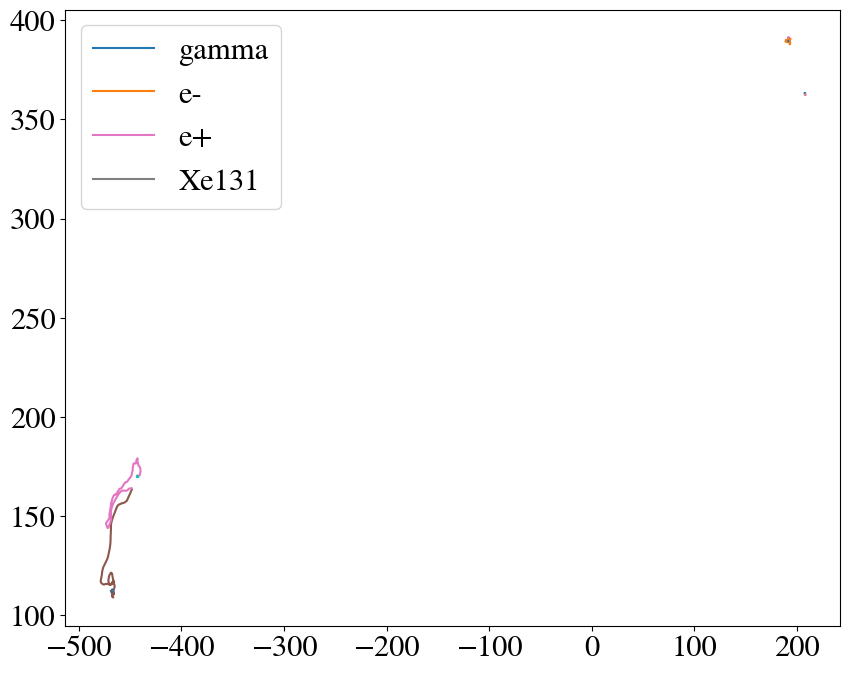

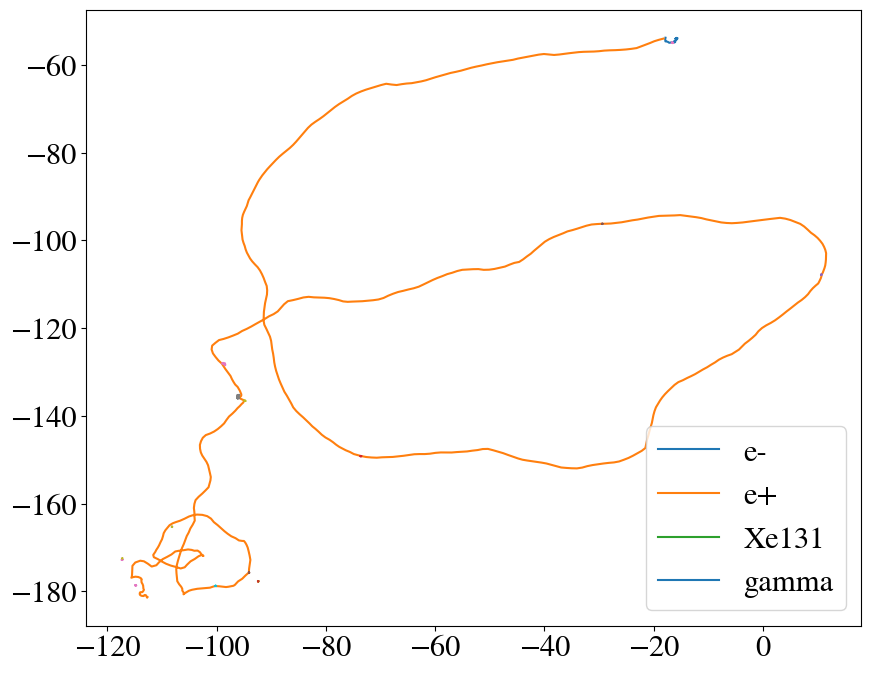

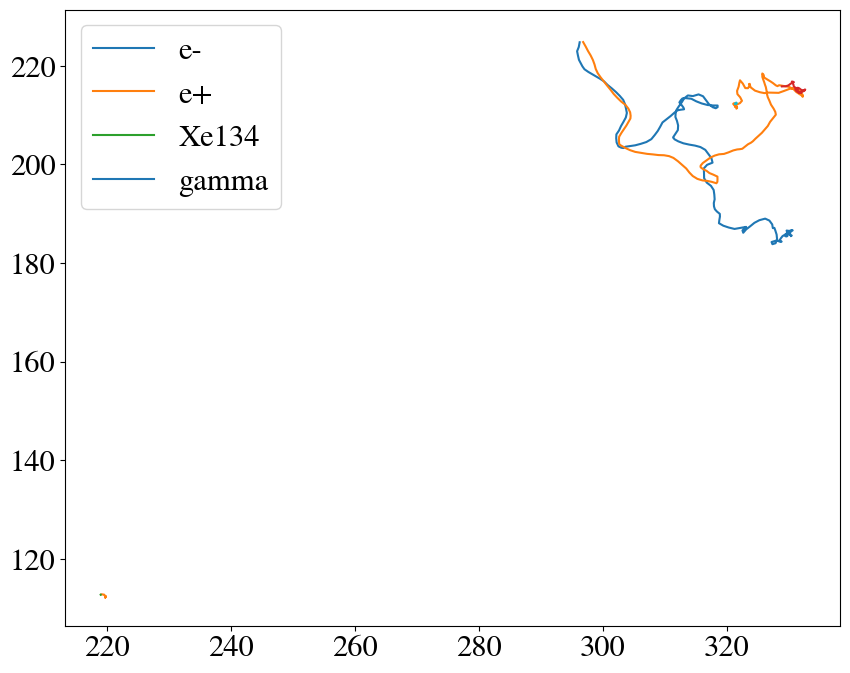

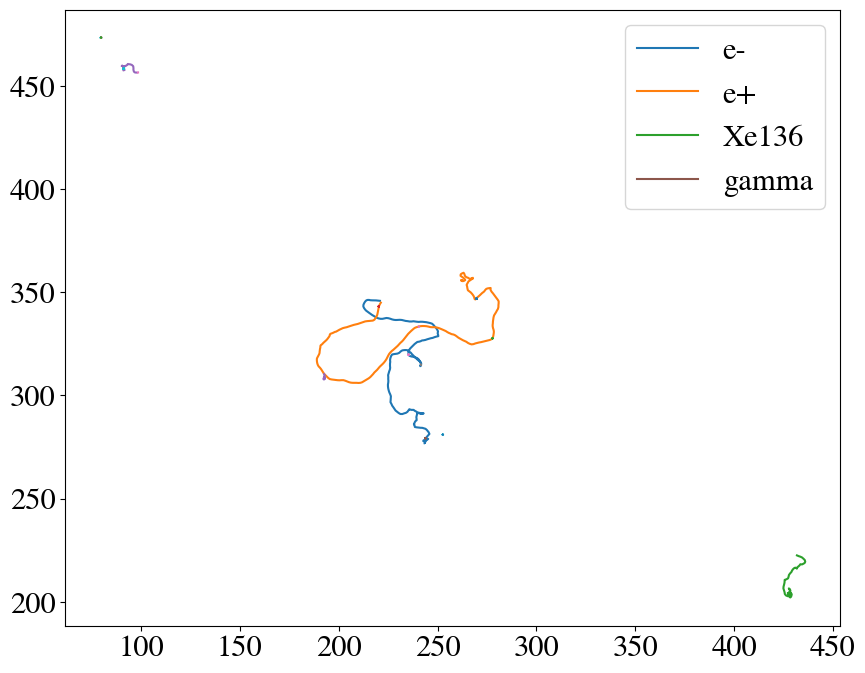

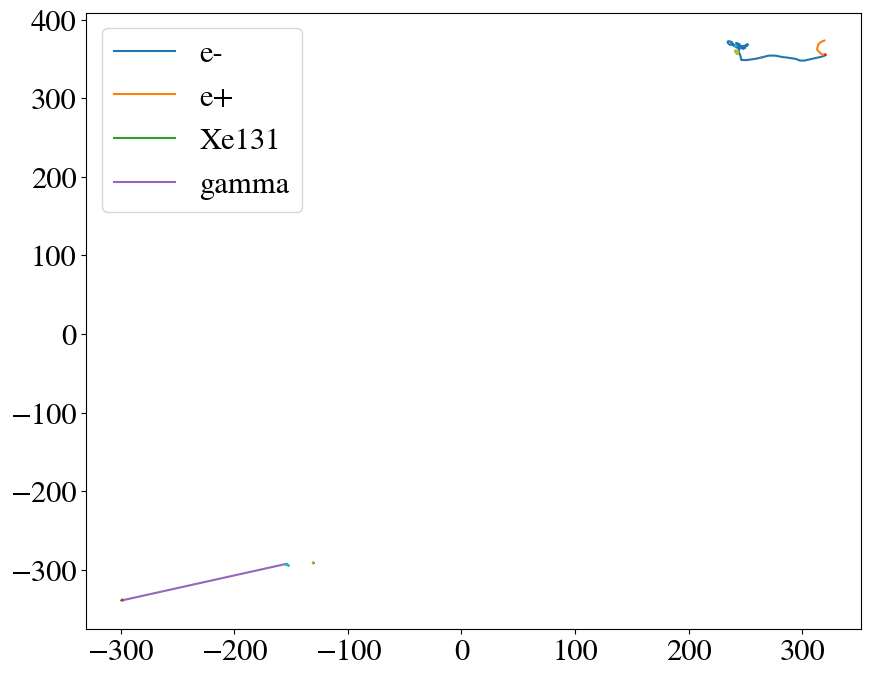

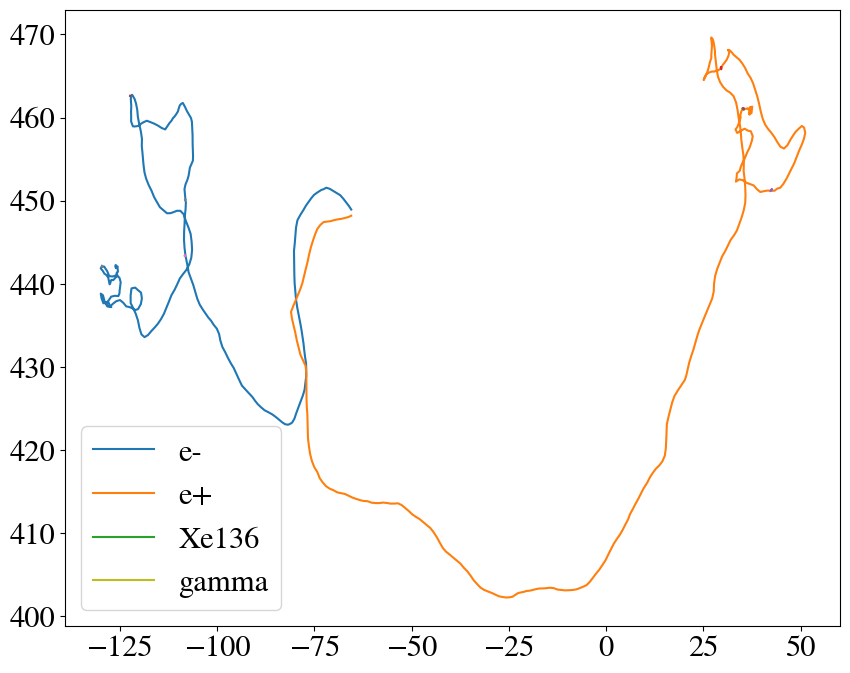

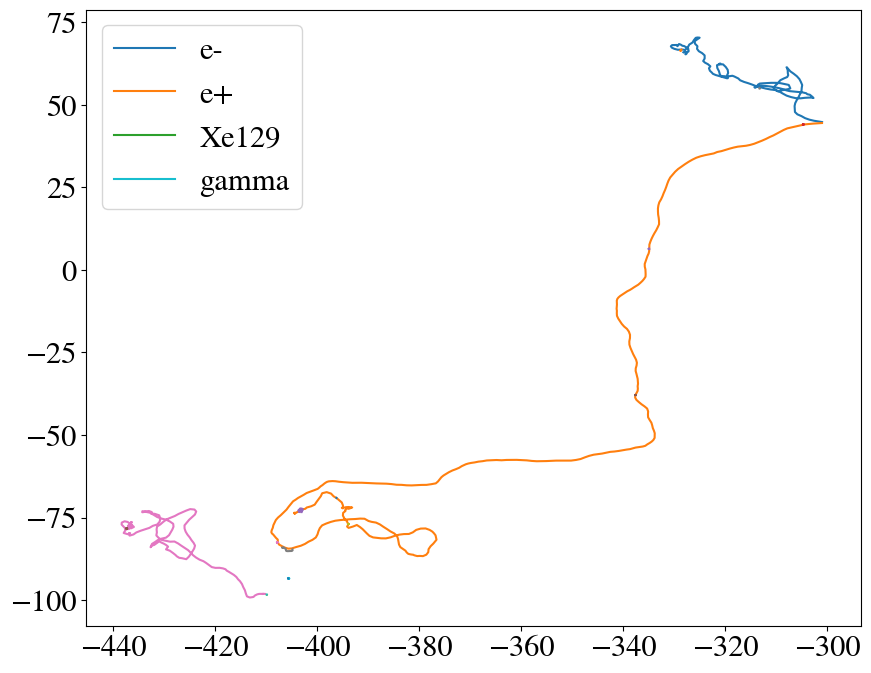

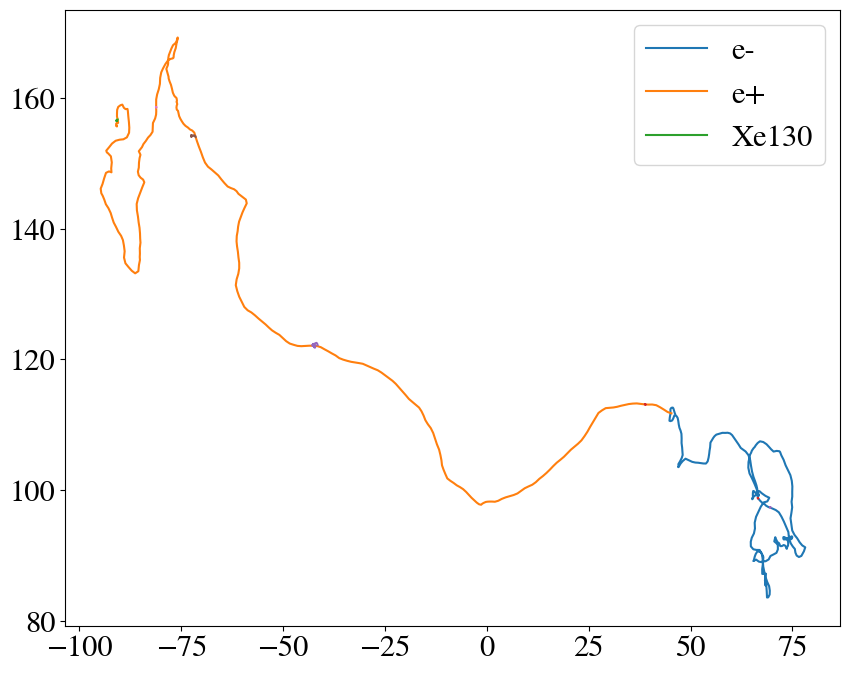

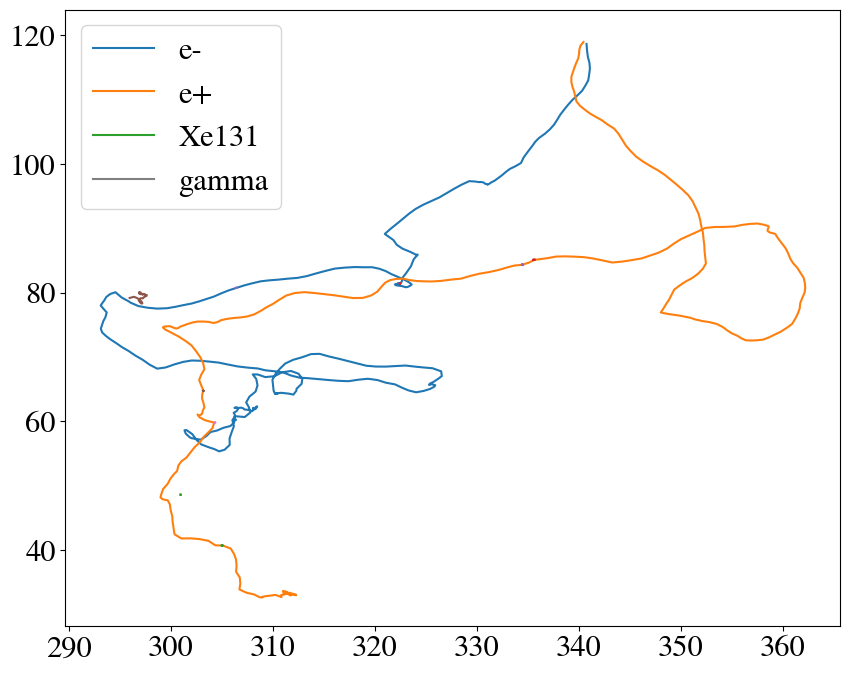

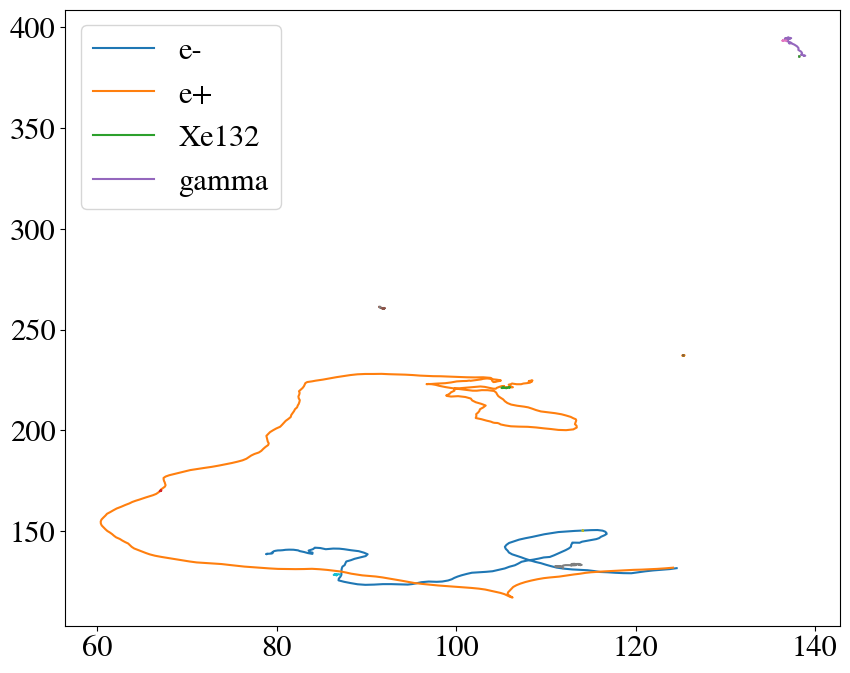

In [8]:
active_volume = MC_df[MC_df.initial_volume == 'ACTIVE']
print(f'Number of events in active volume: {active_volume.event_id.nunique()}')

positrons = active_volume[active_volume['particle_name'] == 'e+']
print(f'Number of positron events: {positrons.event_id.nunique()}')


conv_positrons = positrons[positrons['creator_proc'] == 'conv']
print(f'Number of positron events with conv creator proc: {conv_positrons.event_id.nunique()}')

display(conv_positrons.event_id.unique())

selected_events = conv_positrons.event_id.unique()

selected_events_MC = MC_df[MC_df.event_id.isin(selected_events)]


# printer MC

for evt in selected_events:
    df = hits_df[hits_df.event_id == evt]
    df_MC = MC_df[MC_df.event_id == evt]
    for p_id, df in df.groupby('particle_id'):
        # associate the p_id back to its original from the MC_df
        particle = df_MC[df_MC.particle_id == p_id]
        if not particle.empty:
            particle_name = particle.iloc[0].particle_name
            if particle_name not in plt.gca().get_legend_handles_labels()[1]:
                plt.plot(df.x, df.y, label=f'{particle_name}')
            else:
                plt.plot(df.x, df.y)  # Plot without a label if the name is already used
        else:
            plt.plot(df.x, df.y, label=f'Particle ID: {p_id}, Name: Unknown')
    plt.legend()
    plt.show()


In [9]:
#


MC_df = []

failed_files = 0

for LDC in tqdm(range(2,8)):

    full_path = f'{mc_path}ldc{LDC}/'
    file_names = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f)) and f.endswith('.h5')]    
    try:
        single_df = load_data_fast(full_path)
    except Exception as e:
        failed_files += 1
        print(f'Failed file: {e}')

    # select only ones that are within the active, include positrons and conv
    active_volume = single_df[single_df.initial_volume == 'ACTIVE']

    positrons = active_volume[active_volume['particle_name'] == 'e+']

    conv_positrons = positrons[positrons['creator_proc'] == 'conv']

    
    np.save(f'posi_LDC{LDC}.npz',conv_positrons.event_id.unique())
    del single_df
    del active_volume
    del positrons
    del conv_positrons
    






  0%|                                                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3186_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3202_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3199_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3219_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3207_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc2/NEXT100_Tl208_Port1a_sophronia_3201_thekla.h5 broke with error:
gro

 17%|█████████████████████████████▏                                                                                                                                                 | 1/6 [02:28<12:22, 148.43s/it]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4810_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4824_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4799_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4710_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4798_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc3/NEXT100_Tl208_Port1a_sophronia_4787_thekla.h5 broke with error:
gro

 33%|██████████████████████████████████████████████████████████▎                                                                                                                    | 2/6 [04:59<10:00, 150.20s/it]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_6502_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_5727_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_19738_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_6498_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_6503_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc4/NEXT100_Tl208_Port1a_sophronia_19733_thekla.h5 broke with error:
g

 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 3/6 [07:28<07:28, 149.39s/it]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_8037_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_8396_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_8374_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_8389_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_7682_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc5/NEXT100_Tl208_Port1a_sophronia_15757_thekla.h5 broke with error:
gr

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 4/6 [10:03<05:03, 151.83s/it]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_16750_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_9525_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_10250_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_9771_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_10257_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc6/NEXT100_Tl208_Port1a_sophronia_9759_thekla.h5 broke with error:


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 5/6 [12:38<02:32, 152.71s/it]

File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_11368_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_17988_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_17995_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_12079_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_17985_thekla.h5 broke with error:
group ``/`` does not have a child named ``MC``
File /data/halmazan/NEXT/N100_LPR_MC/250925/thekla/456018/ldc7/NEXT100_Tl208_Port1a_sophronia_17996_thekla.h5 broke with erro

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [15:21<00:00, 153.63s/it]


In [13]:
# compile all the numpy arrays
full_list = []
for LDC in range(1,8):
    x = np.load(f'posi_LDC{LDC}.npz.npy')
    full_list.append(x)

full_list = np.concatenate(full_list)

In [15]:
np.save('MC_truth_FOM/positrons_250925', full_list)

In [17]:
print(len(np.load('MC_truth_FOM/positrons_250925.npy')))


235579
